# Imports

In [ ]:
import sys
sys.path.insert(0, '..')

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from typing import Optional,Tuple
from tqdm import tqdm
from scipy import stats
from scipy.stats import norm


from config import session_length
from DB_connection import DB_connection
from plots import plot_with_flags, plot_proportions_evolution, plot_diversity_evolution
from metrics import compute_lean_score, compute_rank_aware_lean_score, compute_proportions, compute_rank_aware_proportions, compute_shanon_entropy
from query_db_functions import (get_context_videos, get_recommended_videos_during_context_phase, get_chosen_videos_during_navigation_phase,
                                get_recommended_videos_during_navigation_phase, get_sessions_by_profile)

from query_db_functions import (selected_items_lean_and_div_evolution_per_session, recommended_items_lean_and_div_evolution_per_session)


db_connection = DB_connection(expe="expe_1")


# Useful functions

In [3]:
def get_general_anlaysis_for_personas(persona_names, persona_sessions):
    for group,users in zip(persona_names, persona_sessions):
        print(f"For users: {group}")

        all_leans = {
            "context": [],
            "recommended_context": [],
            "rank_aware_recommended_context": [],
            "chosen_navigation": [],
            "recommended_navigation": [],
            "rank_aware_recommended_navigation": []
        }

        all_entropies = {
            "context": [],
            "recommended_context": [],
            "chosen_navigation": [],
            "recommended_navigation": []
        }

        all_proportions = {
            "context": [],
            "recommended_context": [],
            "rank_aware_recommended_context": [],
            "chosen_navigation": [],
            "recommended_navigation": [],
            "rank_aware_recommended_navigation": []
        }


        for session in tqdm(users):
            context_videos = get_context_videos(session)
            recommended_videos_during_context_phase = get_recommended_videos_during_context_phase(session)
            chosen_videos_during_navigation_phase = get_chosen_videos_during_navigation_phase(session)
            recommended_videos_during_navigation_phase = get_recommended_videos_during_navigation_phase(session)

            all_leans["context"].append(compute_lean_score(context_videos))
            all_leans["recommended_context"].append(compute_lean_score(recommended_videos_during_context_phase))
            all_leans["rank_aware_recommended_context"].append(compute_rank_aware_lean_score(recommended_videos_during_context_phase))
            all_leans["chosen_navigation"].append(compute_lean_score(chosen_videos_during_navigation_phase))
            all_leans["recommended_navigation"].append(compute_lean_score(recommended_videos_during_navigation_phase))
            all_leans["rank_aware_recommended_navigation"].append(compute_rank_aware_lean_score(recommended_videos_during_navigation_phase))

            all_entropies["context"].append(compute_shanon_entropy(compute_proportions(context_videos)))
            all_entropies["recommended_context"].append(compute_shanon_entropy(compute_proportions(recommended_videos_during_context_phase)))
            all_entropies["chosen_navigation"].append(compute_shanon_entropy(compute_proportions(chosen_videos_during_navigation_phase)))
            all_entropies["recommended_navigation"].append(compute_shanon_entropy(compute_proportions(recommended_videos_during_navigation_phase)))


            all_proportions["context"].append(compute_proportions(context_videos))
            all_proportions["recommended_context"].append(compute_proportions(recommended_videos_during_context_phase))
            all_proportions["rank_aware_recommended_context"].append(compute_rank_aware_proportions(recommended_videos_during_context_phase))
            all_proportions["chosen_navigation"].append(compute_proportions(chosen_videos_during_navigation_phase))
            all_proportions["recommended_navigation"].append(compute_proportions(recommended_videos_during_navigation_phase))
            all_proportions["rank_aware_recommended_navigation"].append(compute_rank_aware_proportions(recommended_videos_during_navigation_phase))


        mean_proportions = {phase: pd.DataFrame(props).mean().to_dict()
                            for phase, props in all_proportions.items()}
        print("LEAN")
        print('Lean of context videos : ',np.mean(all_leans['context']))
        print('Lean of chosen videos : ',np.mean(all_leans['chosen_navigation']))
        print('Lean of receommended videos during context phase :',np.mean(all_leans['recommended_context']))
        print('Rank-aware Lean of receommended videos during context phase :',np.mean(all_leans['rank_aware_recommended_context']))
        print('Lean of receommended videos during navigation phase :',np.mean(all_leans['recommended_navigation']))
        print('Rank-aware Lean of receommended videos during navigation phase :',np.mean(all_leans['rank_aware_recommended_navigation']))
        print(" ")
        print("PROPORTIONS")
        plot_proportions_evolution(mean_proportions['context'],mean_proportions['chosen_navigation'], 
                                title = f"Distibution of chosen videos for {group} users")
        plot_proportions_evolution( mean_proportions['recommended_context'],mean_proportions['recommended_navigation'],
                                title = f"Distibution of recommended videos for {group} users")
        plot_proportions_evolution( mean_proportions['rank_aware_recommended_context'],mean_proportions['rank_aware_recommended_navigation'],
                                title = f"Distibution of rank-aware recommended videos for {group} users")
        print(mean_proportions['rank_aware_recommended_context'])
        print(mean_proportions['recommended_context'])

        
        print(" ")
        print(" ")


def selected_items_lean_evolution_per_persona(personna: str, window_size: Optional[int] = None) -> list:
    sessions = get_sessions_by_profile(personna)

    all_lean_vectors = []
    all_div_vectors = []
    for session in sessions:
        lean_scores,diversity_scores = selected_items_lean_and_div_evolution_per_session(session, window_size)
        all_lean_vectors.append(lean_scores[:session_length])
        all_div_vectors.append(diversity_scores[:session_length])

    # Convert to numpy array (shape: num_sessions x vector_length)
    all_lean_vectors = np.array(all_lean_vectors)
    mean_lean_vector = np.mean(all_lean_vectors, axis=0)

    all_div_vectors = np.array(all_div_vectors)
    mean_div_vector = np.mean(all_div_vectors,axis=0)


    return mean_lean_vector,mean_div_vector, all_lean_vectors, all_div_vectors


def recommended_items_evolution_per_persona(
    personna: str,
    window_size: Optional[int] = None,
    rank_aware: bool = False
):
    sessions = get_sessions_by_profile(personna)

    all_lean_vectors = []
    all_div_vectors = []
    for session in sessions:
        lean_scores, diversity_scores = recommended_items_lean_and_div_evolution_per_session(
            session, window_size=window_size, rank_aware=rank_aware
        )
        all_lean_vectors.append(lean_scores)
        all_div_vectors.append(diversity_scores)

    # Convert to numpy array (shape: num_sessions x vector_length)
    all_lean_vectors = np.array(all_lean_vectors, dtype=float)
    mean_lean_vector = np.mean(all_lean_vectors, axis=0) if len(all_lean_vectors) else np.array([])

    all_div_vectors = np.array(all_div_vectors, dtype=float)
    mean_div_vector = np.mean(all_div_vectors, axis=0) if len(all_div_vectors) else np.array([])

    return mean_lean_vector, mean_div_vector, all_lean_vectors, all_div_vectors



# 1. General analysis

### Number of videos by stance

In [4]:
print('number undifined videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Undefined' ")))
print('number of unrelated videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Unrelated' ")))
print('number of pro israel videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Pro-Israel' ")))
print('number of pro palestine videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Pro-Palestine' ")))
print('number of neutral videos :',len(db_connection.select("SELECT * FROM annoted_videos WHERE llm_label IS 'Neutral' ")))

number undifined videos : 397
number of unrelated videos : 7969
number of pro israel videos : 4079
number of pro palestine videos : 3862
number of neutral videos : 1794


### Number of sessions per profile

In [5]:
sessions_pro_israel = get_sessions_by_profile('Pro_israel_low_div_En_v3') 
sessions_pro_palestine= get_sessions_by_profile('Pro_palestine_low_div_En_v3')
sessions_neutral = get_sessions_by_profile('Neutral_low_div_En_v3')


print("Number of Pro-Israel sessions :",len(sessions_pro_israel))
print("Number of Pro-Palestine sessions :",len(sessions_pro_palestine))
print("Number of Neutral sessions :", len(sessions_neutral))


Number of Pro-Israel sessions : 52
Number of Pro-Palestine sessions : 57
Number of Neutral sessions : 49


### General analysis for personas

For users: Pro-Israel


100%|██████████| 52/52 [00:33<00:00,  1.56it/s]


LEAN
Lean of context videos :  0.0
Lean of chosen videos :  -0.9342533936651585
Lean of receommended videos during context phase : 0.1733106907923103
Rank-aware Lean of receommended videos during context phase : 0.1691240832934749
Lean of receommended videos during navigation phase : -0.06902637041563045
Rank-aware Lean of receommended videos during navigation phase : -0.08879270060626067
 
PROPORTIONS


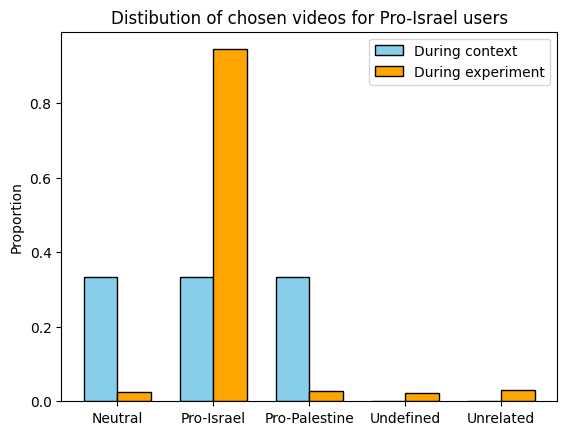

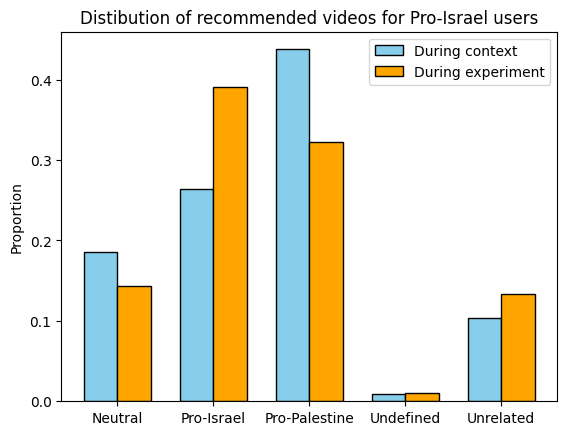

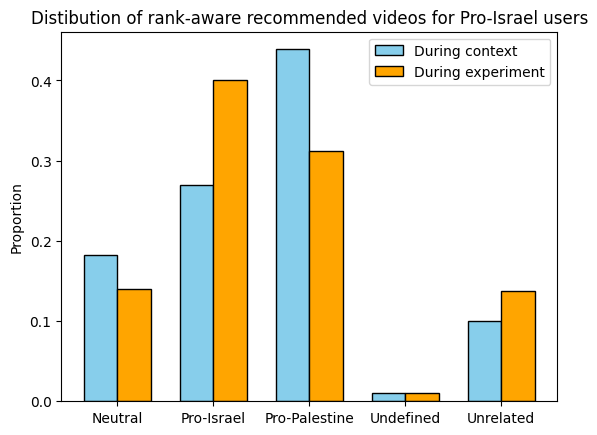

{'Neutral': 0.18184998312926204, 'Pro-Israel': 0.26976505637050824, 'Pro-Palestine': 0.4388891396639832, 'Undefined': 0.01022045794832382, 'Unrelated': 0.09947191015615965}
{'Pro-Palestine': 0.4378017013468835, 'Pro-Israel': 0.2644910105545733, 'Neutral': 0.185296105098967, 'Unrelated': 0.1036120673462803, 'Undefined': 0.008971647332772234}
 
 
For users: Pro-Palestine


100%|██████████| 57/57 [00:36<00:00,  1.55it/s]

LEAN
Lean of context videos :  0.0
Lean of chosen videos :  0.9331584017735858
Lean of receommended videos during context phase : 0.19192939321837188
Rank-aware Lean of receommended videos during context phase : 0.19572929822649862
Lean of receommended videos during navigation phase : 0.5785262421180036
Rank-aware Lean of receommended videos during navigation phase : 0.5925207638794592
 
PROPORTIONS


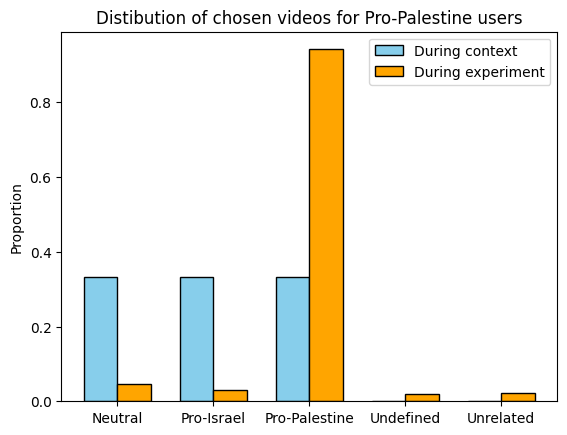

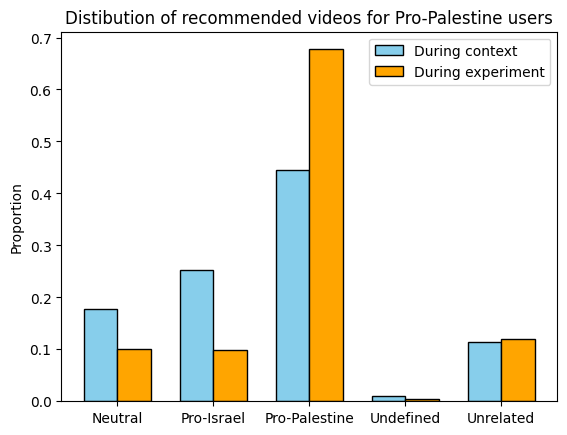

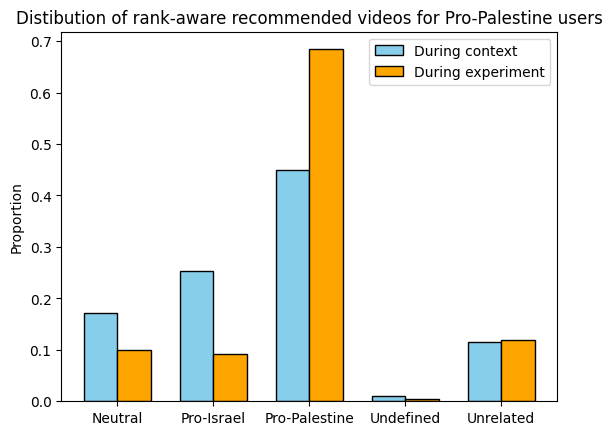

{'Neutral': 0.1720660372615419, 'Pro-Israel': 0.25409694322948956, 'Pro-Palestine': 0.44982624145598815, 'Undefined': 0.009550155848078848, 'Unrelated': 0.11462816879872745}
{'Pro-Palestine': 0.4451232689593882, 'Pro-Israel': 0.2531938757410163, 'Neutral': 0.17761852932108224, 'Unrelated': 0.11498537051303864, 'Undefined': 0.00924107967021524}
 
 
For users: Neutral


100%|██████████| 49/49 [00:31<00:00,  1.54it/s]

LEAN
Lean of context videos :  0.0
Lean of chosen videos :  0.11216941846197322
Lean of receommended videos during context phase : 0.2086945953014896
Rank-aware Lean of receommended videos during context phase : 0.21021165700220498
Lean of receommended videos during navigation phase : 0.24587719132748628
Rank-aware Lean of receommended videos during navigation phase : 0.23315218362764484
 
PROPORTIONS


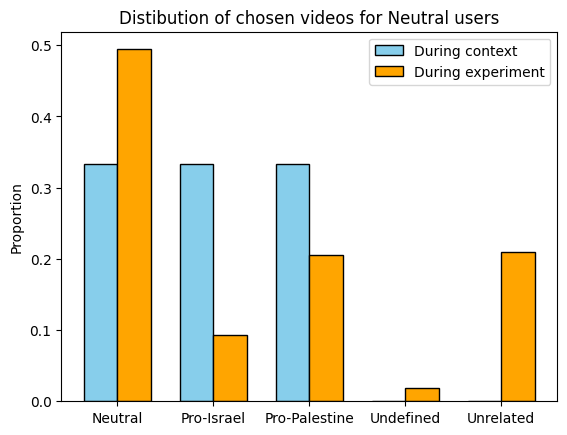

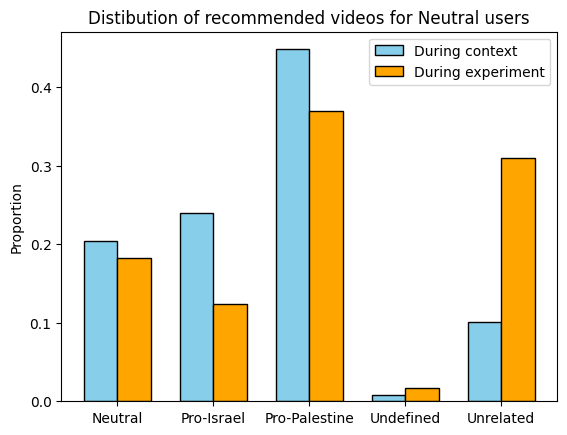

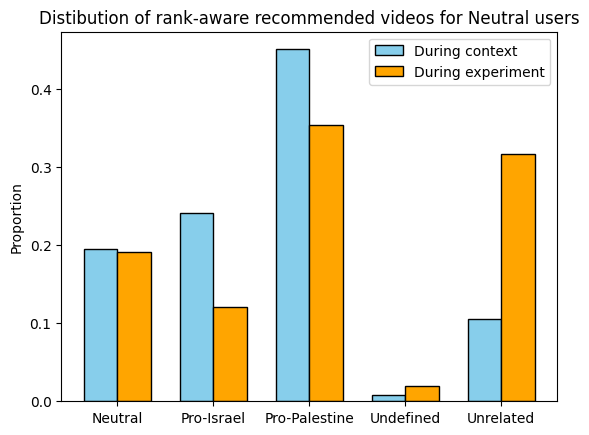

{'Neutral': 0.1949904788413428, 'Pro-Israel': 0.2405477791789869, 'Pro-Palestine': 0.4507594361811919, 'Undefined': 0.0086489807868633, 'Unrelated': 0.10540634463556871}
{'Pro-Palestine': 0.44809315889244766, 'Pro-Israel': 0.23939856359095799, 'Neutral': 0.20431914455846714, 'Unrelated': 0.10029950972492556, 'Undefined': 0.008225351881423036}
 
 


In [6]:
persona_names = ["Pro-Israel","Pro-Palestine","Neutral"]
persona_sessions = [sessions_pro_israel, sessions_pro_palestine, sessions_neutral]
get_general_anlaysis_for_personas(persona_names, persona_sessions)

# 2. Lean and diversity evolution

## 2.1. For chosen items 

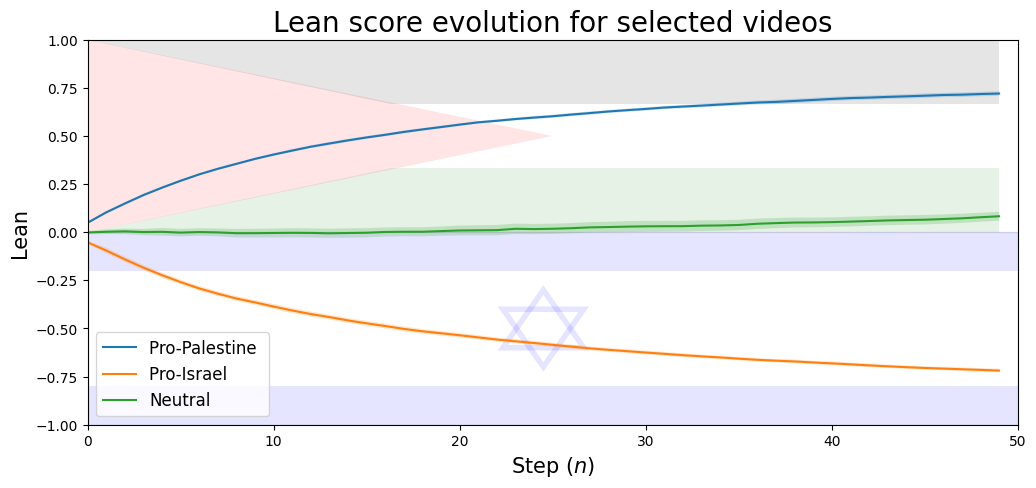

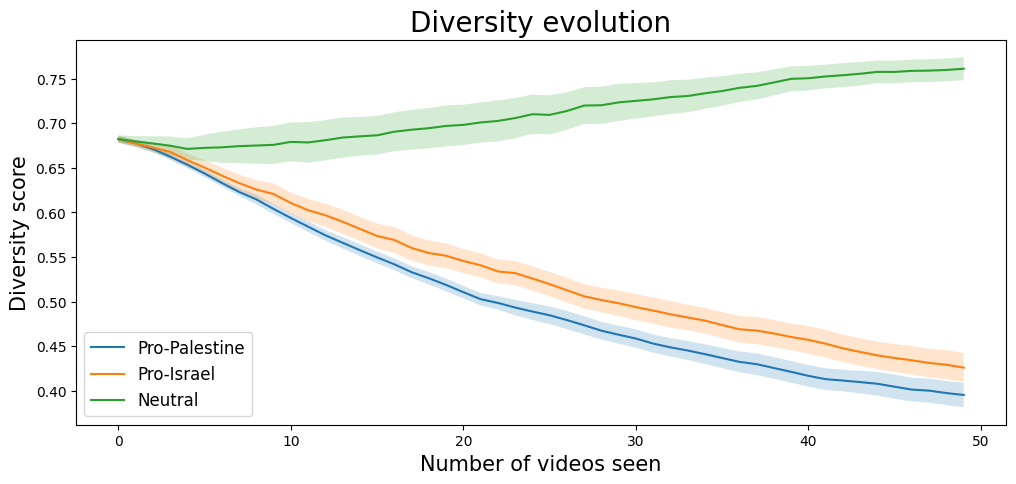

In [6]:
(lean_selected_items_pro_palestine, div_selected_items_pro_palestine, 
all_lean_selected_items_pro_palestine, all_div_selected_items_pro_palestine) = selected_items_lean_evolution_per_persona('Pro_palestine_low_div_En_v3')

(lean_selected_items_pro_israel,div_selected_items_pro_israel,
 all_lean_selected_items_pro_israel, all_div_selected_items_pro_israel) = selected_items_lean_evolution_per_persona('Pro_israel_low_div_En_v3')

(lean_selected_items_neutral, div_selected_items_neutral,
 all_lean_selected_items_neutral, all_div_selected_items_neutral) = selected_items_lean_evolution_per_persona('Neutral_low_div_En_v3')


lean_data = [all_lean_selected_items_pro_palestine, all_lean_selected_items_pro_israel,all_lean_selected_items_neutral]
plot_with_flags(data=lean_data, 
                title="Lean score evolution for selected videos",
                labels=["Pro-Palestine ","Pro-Israel ", "Neutral"], 
                with_confidence_interval=True)


div_data = [all_div_selected_items_pro_palestine,all_div_selected_items_pro_israel,all_div_selected_items_neutral]
plot_diversity_evolution(div_data,
                         title ="Diversity evolution",
                         labels=["Pro-Palestine","Pro-Israel","Neutral"], 
                         with_confidence_interval=True)

## 2.2. For Recommended items

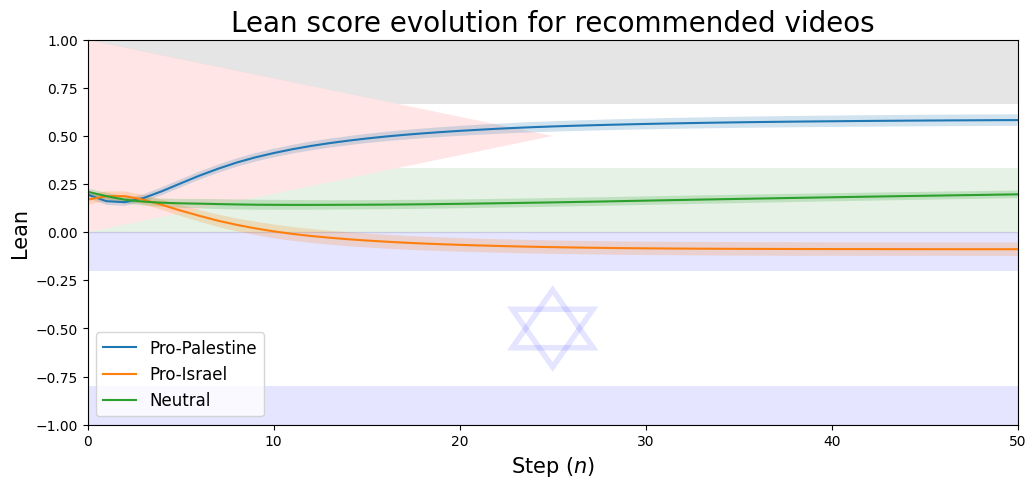

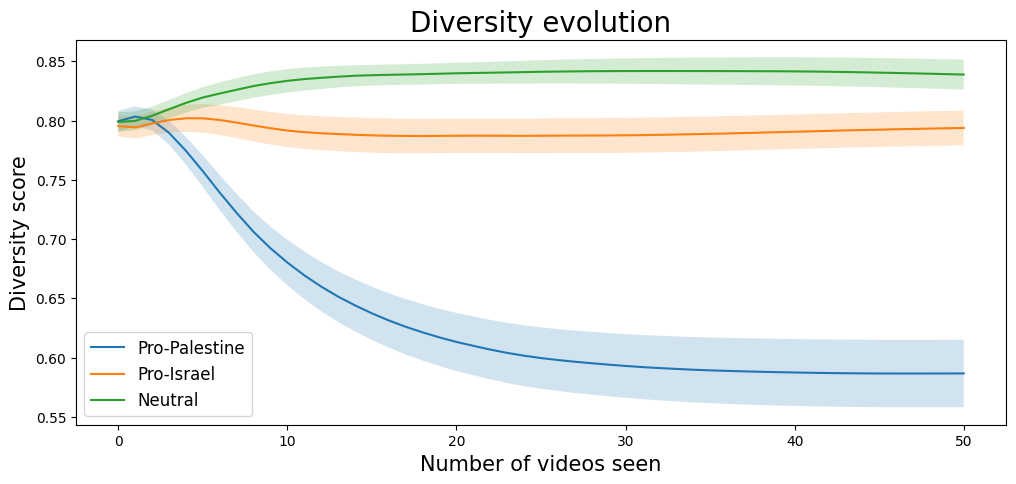

In [7]:
(lean_recommended_iems_pro_palestine, div_recommended_iems_pro_palestine, 
 all_lean_vectors_pro_palestine, all_div_vectors_pro_palestine) = recommended_items_evolution_per_persona(
    'Pro_palestine_low_div_En_v3', rank_aware=True  
)

(lean_recommended_iems_pro_israel, div_recommended_iems_pro_israel, 
 all_lean_vectors_pro_israel, all_div_vectors_pro_israel) = recommended_items_evolution_per_persona(
    'Pro_israel_low_div_En_v3', rank_aware=True
)

(lean_recommended_iems_neutral, div_recommended_iems_neutral, 
 all_lean_vectors_neutral, all_div_vectors_neutral) = recommended_items_evolution_per_persona(
    'Neutral_low_div_En_v3', rank_aware=True
)

data = [
    all_lean_vectors_pro_palestine,
    all_lean_vectors_pro_israel,
    all_lean_vectors_neutral
]


plot_with_flags(
    data=data,
    title="Lean score evolution for recommended videos",
    labels=["Pro-Palestine","Pro-Israel","Neutral"],
    with_confidence_interval=True
)

data = [
    all_div_vectors_pro_palestine,
    all_div_vectors_pro_israel,
    all_div_vectors_neutral
]

plot_diversity_evolution(
    data,
    title="Diversity evolution",
    labels=["Pro-Palestine","Pro-Israel", "Neutral"],
    with_confidence_interval=True
)

# 3. Linear Mixed Models

## 3.1. For Lean 

### Fit model

In [20]:


# ===== choose how many steps to include per user =====
MAX_STEPS = 50   # e.g., first 10 navigation steps

# ---------- 1) Build long dataframe from your arrays ----------
def _stack_persona(all_lean_vectors, persona_label, max_steps=None):
    """Convert per-user lean vectors to long format; optionally truncate to max_steps."""
    rows = []
    for i, vec in enumerate(all_lean_vectors):
        vec = np.asarray(vec, dtype=float)
        mask = np.isfinite(vec)
        if not np.any(mask):
            continue
        steps = np.arange(len(vec))[mask]
        tmp = pd.DataFrame({
            "user_id": f"{persona_label}_{i}",
            "step_idx": steps,
            "lean": vec[mask],
            "persona": persona_label
        })
        if max_steps is not None:
            tmp = tmp[tmp["step_idx"] < max_steps]
        rows.append(tmp)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=["user_id","step_idx","lean","persona"]
    )

# Expect these arrays to exist: all_lean_vectors_pro_palestine, all_lean_vectors_pro_israel, all_lean_vectors_neutral
df_pp  = _stack_persona(all_lean_vectors_pro_palestine, "ProPal", MAX_STEPS)
df_pi  = _stack_persona(all_lean_vectors_pro_israel,    "ProIsr", MAX_STEPS)
df_neu = _stack_persona(all_lean_vectors_neutral,       "Neutral", MAX_STEPS)
df = pd.concat([df_pp, df_pi, df_neu], ignore_index=True)

# ---------- 2) Preprocess ----------
df["step_c"] = df["step_idx"].astype(int)  # 0-based steps → step_c=0 is first post-context step
df["persona"] = pd.Categorical(df["persona"], categories=["Neutral","ProPal","ProIsr"])
df = df[np.isfinite(df["lean"])].copy()

print(f"\nUsing first {MAX_STEPS} steps per user. N={len(df)}, users={df['user_id'].nunique()}.")

# ---------- 3) Fit the REDUCED mixed model (no persona main effects) ----------
# lean ~ β0 + β1*step_c + β2*(step_c:ProPal) + β3*(step_c:ProIsr)
reduced_formula = "lean ~ step_c + step_c:persona"

def fit_mixedlm(data, formula, re_formula):
    md = smf.mixedlm(formula, data, groups=data["user_id"], re_formula=re_formula)
    return md.fit(method="lbfgs", maxiter=500, disp=False)  # REML default is fine

try:
    m = fit_mixedlm(df, reduced_formula, re_formula="~ step_c")   # random intercept + slope
    note = "Model fitted with random intercept + slope."
except Exception:
    m = fit_mixedlm(df, reduced_formula, re_formula="~ 1")        # fallback: random intercept only
    note = "Model fitted with random intercept only."

print("\n===  MixedLM summary ===")
print(m.summary())
print(f"[Note] {note}")




Using first 50 steps per user. N=7900, users=158.

===  MixedLM summary ===
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     lean      
No. Observations:     7900        Method:                 REML      
No. Groups:           158         Scale:                  0.0032    
Min. group size:      50          Log-Likelihood:         10797.0121
Max. group size:      50          Converged:              Yes       
Mean group size:      50.0                                          
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 0.180    0.010  17.358 0.000  0.159  0.200
step_c                    0.001    0.000   1.818 0.069 -0.000  0.001
step_c:persona[T.ProPal]  0.008    0.001  14.143 0.000  0.007  0.009
step_c:persona[T.ProIsr] -0.006    0.000 -

/Users/colintimmers/Documents/PhD/YoutubeStats_project/YoutubeStats_results_analysis/.venv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Test hypothesis

In [21]:
# ---------- 4) Tests ----------
# (a) Initial intercept test: H0: β0 = 0  (baseline at step 0, common to all personas)
beta0 = m.fe_params["Intercept"]
se_beta0 = m.bse_fe["Intercept"]
z0 = beta0 / se_beta0
p0 = 2 * (1 - norm.cdf(abs(z0)))
lo0 = beta0 - 1.96 * se_beta0
hi0 = beta0 + 1.96 * se_beta0
print("\n RQ1")
print("=== Test H0: β0 (Intercept) = 0 ===")
print(f"β0 = {beta0:.6f}, SE = {se_beta0:.6f}, z = {z0:.3f}, p = {p0:.4g}")
print(f"95% CI: [{lo0:.6f}, {hi0:.6f}]")
print("→ Significant baseline algorithmic bias." if p0 < 0.05 else "→ No significant baseline algorithmic bias detected.")

# (b) Interaction slope tests: H0: β2 = 0 and H0: β3 = 0
print("\n RQ2.1")
term_pp = "step_c:persona[T.ProPal]"  # β2
term_pi = "step_c:persona[T.ProIsr]"  # β3

def z_test_term(model, term):
    if term not in model.bse_fe.index:
        print(f"\n[Warn] Term '{term}' not found among fixed effects (maybe aliased).")
        return None
    est = model.fe_params[term]
    se  = model.bse_fe[term]
    z   = est / se
    p   = 2 * (1 - norm.cdf(abs(z)))
    lo  = est - 1.96 * se
    hi  = est + 1.96 * se
    print(f"=== Test H0: {term} = 0 ===")
    print(f"{term}: estimate = {est:.6f}, SE = {se:.6f}, z = {z:.3f}, p = {p:.4g}")
    print(f"95% CI: [{lo:.6f}, {hi:.6f}]")
    print("→ Significant lean evolution towards user lean."
          if p < 0.05 else "→ No significant lean evolution towards user lean.")
    return est, se, z, p, lo, hi

res_pp = z_test_term(m, term_pp)  # β2
res_pi = z_test_term(m, term_pi)  # β3

# ---------- 5b) Test H0: |β2| = |β3| ----------
if term_pp in m.fe_params.index and term_pi in m.fe_params.index:
    b2, b3 = m.fe_params[term_pp], m.fe_params[term_pi]
    cov = m.cov_params()
    v2 = cov.loc[term_pp, term_pp]
    v3 = cov.loc[term_pi, term_pi]
    cov23 = cov.loc[term_pp, term_pi]
    
    # Delta-method approximation for abs difference
    diff_abs = abs(b2) - abs(b3)
    sign2, sign3 = np.sign(b2), np.sign(b3)
    var_abs = (sign2**2 * v2) + (sign3**2 * v3) - 2 * sign2 * sign3 * cov23
    se_abs = np.sqrt(var_abs)
    
    z_abs = diff_abs / se_abs
    p_abs = 2 * (1 - norm.cdf(abs(z_abs)))
    lo_abs = diff_abs - 1.96 * se_abs
    hi_abs = diff_abs + 1.96 * se_abs

    print("\n RQ2.3")
    print("=== Test H0: |β2| - |β3| = 0  ===")
    print(f"|β2| - |β3| = {diff_abs:.6f}, SE = {se_abs:.6f}, z = {z_abs:.3f}, p = {p_abs:.4g}")
    print(f"95% CI: [{lo_abs:.6f}, {hi_abs:.6f}]")
    print("→ Significant difference in *magnitude* of slopes."
          if p_abs < 0.05 else "→ No significant difference in slope magnitudes.")
else:
    print("\n[Warn] One or both interaction terms not found — cannot test |β2| - |β3| difference.")


 RQ1
=== Test H0: β0 (Intercept) = 0 ===
β0 = 0.179595, SE = 0.010347, z = 17.358, p = 0
95% CI: [0.159315, 0.199874]
→ Significant baseline algorithmic bias.

 RQ2.1
=== Test H0: step_c:persona[T.ProPal] = 0 ===
step_c:persona[T.ProPal]: estimate = 0.007582, SE = 0.000536, z = 14.143, p = 0
95% CI: [0.006532, 0.008633]
→ Significant lean evolution towards user lean.
=== Test H0: step_c:persona[T.ProIsr] = 0 ===
step_c:persona[T.ProIsr]: estimate = -0.005800, SE = 0.000464, z = -12.502, p = 0
95% CI: [-0.006709, -0.004890]
→ Significant lean evolution towards user lean.

 RQ2.3
=== Test H0: |β2| - |β3| = 0  ===
|β2| - |β3| = 0.001783, SE = 0.000792, z = 2.250, p = 0.02446
95% CI: [0.000230, 0.003336]
→ Significant difference in *magnitude* of slopes.


## 3.2. For diversity

In [22]:
# ===== choose how many steps to include per user =====
MAX_STEPS = 50   # e.g., first 10 navigation steps

# ---------- 1) Build long dataframe from your arrays ----------
def _stack_persona(all_div_vectors, persona_label, max_steps=None):
    """Convert per-user lean vectors to long format; optionally truncate to max_steps."""
    rows = []
    for i, vec in enumerate(all_div_vectors):
        vec = np.asarray(vec, dtype=float)
        mask = np.isfinite(vec)
        if not np.any(mask):
            continue
        steps = np.arange(len(vec))[mask]
        tmp = pd.DataFrame({
            "user_id": f"{persona_label}_{i}",
            "step_idx": steps,
            "div": vec[mask],
            "persona": persona_label
        })
        if max_steps is not None:
            tmp = tmp[tmp["step_idx"] < max_steps]
        rows.append(tmp)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=["user_id","step_idx","div","persona"]
    )

# Expect these arrays to exist: all_lean_vectors_pro_palestine, all_lean_vectors_pro_israel, all_lean_vectors_neutral
df_pp  = _stack_persona(all_div_vectors_pro_palestine, "ProPal", MAX_STEPS)
df_pi  = _stack_persona(all_div_vectors_pro_israel,    "ProIsr", MAX_STEPS)
df_neu = _stack_persona(all_div_vectors_neutral,       "Neutral", MAX_STEPS)
df = pd.concat([df_pp, df_pi, df_neu], ignore_index=True)

# ---------- 2) Preprocess ----------
df["step_c"] = df["step_idx"].astype(int)  # 0-based steps → step_c=0 is first post-context step
df["persona"] = pd.Categorical(df["persona"], categories=["Neutral","ProPal","ProIsr"])
df = df[np.isfinite(df["div"])].copy()

print(f"\nUsing first {MAX_STEPS} steps per user. N={len(df)}, users={df['user_id'].nunique()}.")

# ---------- 3) Fit the REDUCED mixed model (no persona main effects) ----------
# div ~ β0 + β1*step_c + β2*(step_c:ProPal) + β3*(step_c:ProIsr)
reduced_formula = "div ~ step_c + step_c:persona"

def fit_mixedlm(data, formula, re_formula):
    md = smf.mixedlm(formula, data, groups=data["user_id"], re_formula=re_formula)
    return md.fit(method="lbfgs", maxiter=500, disp=False)  # REML default is fine

try:
    m = fit_mixedlm(df, reduced_formula, re_formula="~ step_c")   # random intercept + slope
    note = "Model fitted with random intercept + slope."
except Exception:
    m = fit_mixedlm(df, reduced_formula, re_formula="~ 1")        # fallback: random intercept only
    note = "Model fitted with random intercept only."

print("\n===  MixedLM summary ===")
print(m.summary())
print(f"[Note] {note}")


Using first 50 steps per user. N=7900, users=158.

===  MixedLM summary ===
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     div       
No. Observations:     7900        Method:                 REML      
No. Groups:           158         Scale:                  0.0007    
Min. group size:      50          Log-Likelihood:         16864.1279
Max. group size:      50          Converged:              Yes       
Mean group size:      50.0                                          
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 0.781    0.005 168.077 0.000  0.772  0.790
step_c                    0.000    0.000   1.811 0.070 -0.000  0.001
step_c:persona[T.ProPal] -0.004    0.000 -11.493 0.000 -0.005 -0.004
step_c:persona[T.ProIsr] -0.001    0.000  

/Users/colintimmers/Documents/PhD/YoutubeStats_project/YoutubeStats_results_analysis/.venv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [26]:
# ---------- 4) Tests ----------

# (b) Interaction slope tests: H0: β2 = 0 and H0: β3 = 0
print("\n RQ2.2")
term_pp = "step_c:persona[T.ProPal]"  # β2
term_pi = "step_c:persona[T.ProIsr]"  # β3

def z_test_term(model, term):
    if term not in model.bse_fe.index:
        print(f"\n[Warn] Term '{term}' not found among fixed effects (maybe aliased).")
        return None
    est = model.fe_params[term]
    se  = model.bse_fe[term]
    z   = est / se
    p   = 2 * (1 - norm.cdf(abs(z)))
    lo  = est - 1.96 * se
    hi  = est + 1.96 * se
    print(f"=== Test H0: {term} = 0 ===")
    print(f"{term}: estimate = {est:.6f}, SE = {se:.6f}, z = {z:.3f}, p = {p:.4g}")
    print(f"95% CI: [{lo:.6f}, {hi:.6f}]")
    print("→ Significant lean evolution towards user lean."
          if p < 0.05 else "→ No significant lean evolution towards user lean.")
    return est, se, z, p, lo, hi

res_pp = z_test_term(m, term_pp)  # β2
res_pi = z_test_term(m, term_pi)  # β3

# ---------- 5) Test if β2 and β3 differ significantly ----------
term_pp = "step_c:persona[T.ProPal]"
term_pi = "step_c:persona[T.ProIsr]"

if term_pp in m.fe_params.index and term_pi in m.fe_params.index:
    b2, b3 = m.fe_params[term_pp], m.fe_params[term_pi]
    cov = m.cov_params()
    v2 = cov.loc[term_pp, term_pp]
    v3 = cov.loc[term_pi, term_pi]
    cov23 = cov.loc[term_pp, term_pi]
    
    diff = b2 - b3
    se_diff = np.sqrt(v2 + v3 - 2 * cov23)
    z_diff = diff / se_diff
    p_diff = 2 * (1 - norm.cdf(abs(z_diff)))
    lo_diff = diff - 1.96 * se_diff
    hi_diff = diff + 1.96 * se_diff

    print("\n=== Test H0: β2 - β3 = 0 ===")
    print(f"β2 - β3 = {diff:.6f}, SE = {se_diff:.6f}, z = {z_diff:.3f}, p = {p_diff:.4g}")
    print(f"95% CI: [{lo_diff:.6f}, {hi_diff:.6f}]")
    print("→ Significant difference between ProPal and ProIsr slopes." if p_diff < 0.05 else
          "→ No significant difference between ProPal and ProIsr slopes.")
else:
    print("\n[Warn] One or both interaction terms not found — cannot test β2 - β3 difference.")




 RQ2.2
=== Test H0: step_c:persona[T.ProPal] = 0 ===
step_c:persona[T.ProPal]: estimate = -0.004299, SE = 0.000374, z = -11.493, p = 0
95% CI: [-0.005033, -0.003566]
→ Significant lean evolution towards user lean.
=== Test H0: step_c:persona[T.ProIsr] = 0 ===
step_c:persona[T.ProIsr]: estimate = -0.000581, SE = 0.000309, z = -1.882, p = 0.05987
95% CI: [-0.001186, 0.000024]
→ No significant lean evolution towards user lean.

=== Test H0: β2 - β3 = 0 ===
β2 - β3 = -0.003719, SE = 0.000329, z = -11.308, p = 0
95% CI: [-0.004363, -0.003074]
→ Significant difference between ProPal and ProIsr slopes.
